# API Request notebook for climate and air quality data from Copernicus Atmosphere Monitoring Service (CAMS) and Copernicus Climate Change Service (C3S)

This notebook is used to download data derived from meteorological and air quality models. It's divided into 2 parts:
- The first part requests data using **CDS API** Python library. It's used to download data concerning air quality variables from Copernicus Atmosphere Monitoring Service (CAMS) model.
- The second part requests data using **Google Earth Engine** Python API library. It's used to dowload data concerning meteorological variables obtained from the Compernicus Climate Change Servince ERA5-land hourly Reanalysis model.

### Link to Copernicus Services:
- Link to ADS Atmosphere Copernicus (CAMS): https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview
- Link to CDS Climate Copernicus (C3S): https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview

### How to access the CDS API:
It's possible to change **key** and **value** provided from the website in the **.cdsapirc** file as explained in the following link:
- Air quality model data from CAMS: https://ads.atmosphere.copernicus.eu/api-how-to 

Otherwise **key** and **value** can be used as input directly inside the **cdsapi** API request.

### Reference material:<br> 
- GitHub Repository containing examples from ECMWF: https://github.com/ecmwf-projects/copernicus-training
- Example: https://github.com/ecmwf-projects/copernicus-training/blob/master/2021-02-Copernicus-ECMWF-data-tutorial.ipynb

### Import libraries and API authentication

In [2]:
import cdsapi
import os
import geopandas as gpd
import xarray as xr
import json
import ipywidgets as widgets
import ee
import geemap

import warnings
warnings.filterwarnings('ignore')

# Import functions defined for DDUST project:
from functions import my_methods

C:\Users\Administrator\anaconda3\envs\ddust\lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [3]:
# Google Earth Engine authentication (a Google account is required):
ee.Authenticate()

Enter verification code:  4/1AX4XfWg6xhDY1i-uc9Wr5Aq6BUg6iGf36yXmyWPgmH0ew-hSTeONwAABYyQ



Successfully saved authorization token.


In [3]:
# Initialize Google Earth Engine API:
ee.Initialize()

In [3]:
# CDSAPI: Importing key/value from .json file for API authentication:
f = open('keys.json')
keys = json.load(f)
c_atm = cdsapi.Client(keys["ATM_ID"], keys["ATM_KEY"])

In [3]:
# Current working directory path:
cwd = os.getcwd()

### Set starting and end date for data request:

The date selection is done through the **date.json** file that contains as **keys** the crop name (e.g. cereal_week) and as **values** a list of the corresponding manuring/observation weeks. The  **date.json** file is the same for all the project's notebooks:

In [8]:
d = open('date.json')
date = json.load(d)
year = date['year']
mais_week = date['mais_week']
rice_week = date['rice_week']
cereal_week = date['cereal_week']
custom_week = date['custom_week']

The calendar **manuring_periods** functions allows to create and visualize the calendar with corresponding manuring weeks:

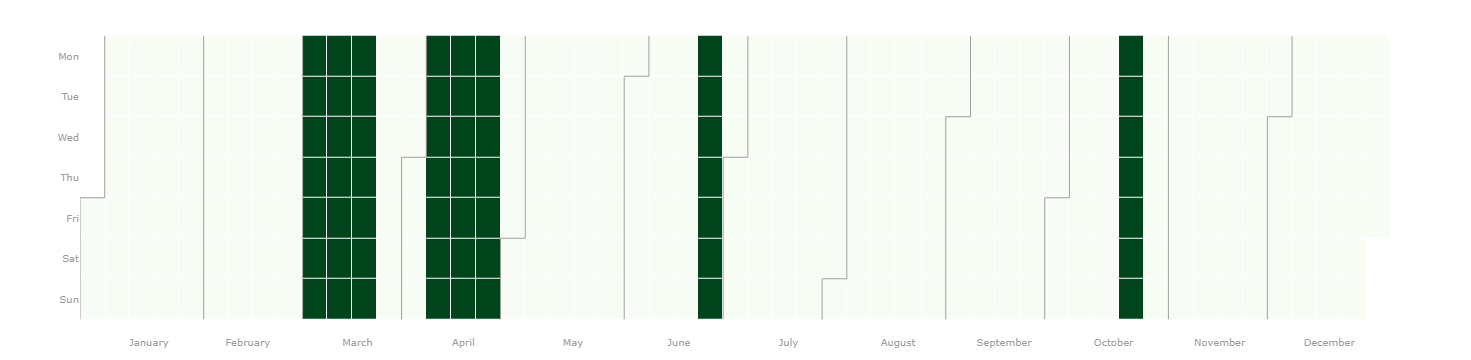

In [9]:
calendar = my_methods.manuring_periods(year, mais_week, rice_week, cereal_week, custom_week)

In [10]:
# With this widget is possible to select from the dropdown list the required week
select_week = widgets.Dropdown(
    options=['mais_week', 'rice_week', 'cereal_week', 'custom_week'],
    description='Week:',
    disabled=False)
select_week

Dropdown(description='Week:', options=('mais_week', 'rice_week', 'cereal_week', 'custom_week'), value='mais_we…

In [10]:
# Select start and end date of the corresponding selected week:
start_date = calendar[date[select_week.value][0]][0]
end_date = calendar[date[select_week.value][-1]][-1]
print("For", select_week.value, "the starting date is", start_date,"and the ending date is" , end_date)

For mais_week the starting date is 2021-03-01 and the ending date is 2021-03-21


### Import Bounding Box

In [4]:
area_path = cwd + '/grid/grid_cams.gpkg'
area = gpd.read_file(area_path).to_crs(4326)
bounds = area.total_bounds

In [12]:
# Define a Region Of Interest using a Bounding Box ("roi" variable is used in GEE API only, while
#in CDAPI the Bounding Box coordinates are given directly in the request)
roi = ee.Geometry.BBox(bounds[0],bounds[1],bounds[2],bounds[3])

In [13]:
start_date = calendar[date[select_week.value][0]][0]
end_date = calendar[date[select_week.value][-1]][-1]

- - -

# CDAPI Data Requests for Copernicus Atmosphere Monitoring Service (CAMS)

This part contains the requests for the following variables:
- PM2.5
- Ammonia NH3
- Sulphur Dioxide SO2
- Nitrogen Dioxide NO2
- Nitrogen Monoxide NO
- Carbon Monoxide CO
- Ozone O3
- Dust
- PM10
- NMVOCs (Non-Methane Volatile Organic Compounds)

Each section just requires hourly data in the time range (start & end date) for each variable. The data are required in the bounding box only, and a mean value it's calculated. The output format is a netCDF file.

# [PM2.5 - Particulate Matter](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview) 

In [14]:
pm25_path = cwd+r'\temp\pm25_cams.nc'
pm25 = c_atm.retrieve(
    'cams-europe-air-quality-forecasts',
    {
        'variable': 'particulate_matter_2.5um',
        'model': 'ensemble',
        'level': '0',
        'date': start_date+'/'+end_date,
        'type': 'analysis',
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'leadtime_hour': '0',
        'area': [
            bounds[3], bounds[0], bounds[1],
            bounds[2],
        ],
        'format': 'netcdf',
    },
    pm25_path
    )

2022-04-05 10:10:11,973 INFO Welcome to the CDS
2022-04-05 10:10:11,974 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts
2022-04-05 10:10:12,030 INFO Request is queued
2022-04-05 10:10:13,093 INFO Request is running
2022-04-05 10:13:03,866 INFO Request is completed
2022-04-05 10:13:03,867 INFO Downloading https://download-0002-ads-clone.copernicus-climate.eu/cache-compute-0002/cache/data4/adaptor.cams_regional_fc.retrieve-1649146337.100575-11017-6-c5efd161-42ae-4cb8-8fbe-c923e32e2bb1.nc to C:\Users\Administrator\OneDrive - Politecnico di Milano\WP2\D-DUST\temp\pm25_cams.nc (1.6M)
2022-04-05 10:13:04,248 INFO Download rate 4.2M/s   


In [15]:
pm25 = xr.open_dataset(pm25_path)

In [16]:
pm25_mean = pm25.mean(dim='time')

In [17]:
pm25_mean.to_netcdf(cwd+r'\temp\pm25_cams.nc')

- - -

# [NH3 - Ammonia](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview) 

In [18]:
nh3_path = cwd+r'\temp\nh3_cams.nc'
nh3 = c_atm.retrieve(
    'cams-europe-air-quality-forecasts',
    {
        'variable': 'ammonia',
        'model': 'ensemble',
        'level': '0',
        'date': start_date+'/'+end_date,
        'type': 'analysis',
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'leadtime_hour': '0',
        'area': [
            bounds[3], bounds[0], bounds[1],
            bounds[2],
        ],
        'format': 'netcdf',
    },
    nh3_path
    )

2022-04-05 10:13:04,566 INFO Welcome to the CDS
2022-04-05 10:13:04,567 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts
2022-04-05 10:13:04,605 INFO Request is queued
2022-04-05 10:13:05,638 INFO Request is running
2022-04-05 10:14:58,314 INFO Request is completed
2022-04-05 10:14:58,315 INFO Downloading https://download-0000-ads-clone.copernicus-climate.eu/cache-compute-0000/cache/data2/adaptor.cams_regional_fc.retrieve-1649146470.486371-17646-13-edbc10f4-13f4-4384-9b23-97d0607f5c82.nc to C:\Users\Administrator\OneDrive - Politecnico di Milano\WP2\D-DUST\temp\nh3_cams.nc (1.6M)
2022-04-05 10:14:58,762 INFO Download rate 3.6M/s   


In [19]:
nh3 = xr.open_dataset(nh3_path)

In [20]:
nh3_mean = nh3.mean(dim='time')

In [21]:
nh3_mean.to_netcdf(cwd+r'\temp\nh3_cams.nc', 'w')

- - -

# [SO2 - Sulphur Dioxide](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview) 

Download and write .nc file for sulphur sioxide (SO2) over the study area:

In [22]:
so2_path = cwd + r'/temp/so2_cams.nc'
so2 = c_atm.retrieve(
    'cams-europe-air-quality-forecasts',
    {
        'variable': 'sulphur_dioxide',
        'model': 'ensemble',
        'level': '0',
        'date': start_date+'/'+end_date,
        'type': 'analysis',
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'leadtime_hour': '0',
        'area': [
            bounds[3], bounds[0], bounds[1],
            bounds[2],
        ],
        'format': 'netcdf',
    },
    so2_path
    )

2022-04-05 10:14:58,897 INFO Welcome to the CDS
2022-04-05 10:14:58,898 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts
2022-04-05 10:14:58,936 INFO Request is queued
2022-04-05 10:14:59,971 INFO Request is running
2022-04-05 10:16:52,662 INFO Request is completed
2022-04-05 10:16:52,663 INFO Downloading https://download-0002-ads-clone.copernicus-climate.eu/cache-compute-0002/cache/data0/adaptor.cams_regional_fc.retrieve-1649146588.1633084-16069-8-3ce37bd7-f3aa-40bd-87b5-de3351acc1de.nc to C:\Users\Administrator\OneDrive - Politecnico di Milano\WP2\D-DUST/temp/so2_cams.nc (1.6M)
2022-04-05 10:16:53,071 INFO Download rate 3.9M/s   


In [23]:
so2 = xr.open_dataset(so2_path)

In [24]:
so2_mean = so2.mean(dim='time')

In [25]:
so2_mean.to_netcdf(so2_path)

- - -

# [NO2 - Nitrogen Dioxide](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview) 

In [26]:
no2_path = cwd + r'/temp/no2_cams.nc'
no2 = c_atm.retrieve(
    'cams-europe-air-quality-forecasts',
    {
        'variable': 'nitrogen_dioxide',
        'model': 'ensemble',
        'level': '0',
        'date': start_date+'/'+end_date,
        'type': 'analysis',
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'leadtime_hour': '0',
        'area': [
            bounds[3], bounds[0], bounds[1],
            bounds[2],
        ],
        'format': 'netcdf',
    },
    no2_path
    )

2022-04-05 10:16:53,213 INFO Welcome to the CDS
2022-04-05 10:16:53,214 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts
2022-04-05 10:16:53,259 INFO Request is queued
2022-04-05 10:16:54,301 INFO Request is running
2022-04-05 10:18:46,988 INFO Request is completed
2022-04-05 10:18:46,988 INFO Downloading https://download-0002-ads-clone.copernicus-climate.eu/cache-compute-0002/cache/data0/adaptor.cams_regional_fc.retrieve-1649146701.3324254-16934-8-5f6b3355-92bf-4929-babd-bd17248db716.nc to C:\Users\Administrator\OneDrive - Politecnico di Milano\WP2\D-DUST/temp/no2_cams.nc (1.6M)
2022-04-05 10:18:47,338 INFO Download rate 4.6M/s   


In [27]:
no2 = xr.open_dataset(no2_path)

In [28]:
no2_mean = no2.mean(dim='time')

In [29]:
no2_mean.to_netcdf(no2_path)

- - -

# [NO - Nitrogen Monoxide](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview)

In [30]:
no_path = cwd + r'/temp/no_cams.nc'
no = c_atm.retrieve(
    'cams-europe-air-quality-forecasts',
    {
        'variable': 'nitrogen_monoxide',
        'model': 'ensemble',
        'level': '0',
        'date': start_date+'/'+end_date,
        'type': 'analysis',
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'leadtime_hour': '0',
        'area': [
            bounds[3], bounds[0], bounds[1],
            bounds[2],
        ],
        'format': 'netcdf',
    },
    no_path
    )

2022-04-05 10:18:47,483 INFO Welcome to the CDS
2022-04-05 10:18:47,484 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts
2022-04-05 10:18:47,524 INFO Request is queued
2022-04-05 10:18:48,568 INFO Request is running
2022-04-05 10:20:41,277 INFO Request is completed
2022-04-05 10:20:41,278 INFO Downloading https://download-0002-ads-clone.copernicus-climate.eu/cache-compute-0002/cache/data1/adaptor.cams_regional_fc.retrieve-1649146815.7812655-11017-14-b774c18f-ba41-41cb-87ee-1d4a8c516e17.nc to C:\Users\Administrator\OneDrive - Politecnico di Milano\WP2\D-DUST/temp/no_cams.nc (1.6M)
2022-04-05 10:20:41,598 INFO Download rate 5M/s     


In [31]:
no = xr.open_dataset(no_path)

In [32]:
no_mean = no.mean(dim='time')

In [33]:
no_mean.to_netcdf(no_path)

- - -

# [CO - Carbon Monoxide](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview)

In [34]:
co_path = cwd + r'/temp/co_cams.nc'
co = c_atm.retrieve(
    'cams-europe-air-quality-forecasts',
    {
        'variable': 'carbon_monoxide',
        'model': 'ensemble',
        'level': '0',
        'date': start_date+'/'+end_date,
        'type': 'analysis',
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'leadtime_hour': '0',
        'area': [
            bounds[3], bounds[0], bounds[1],
            bounds[2],
        ],
        'format': 'netcdf',
    },
    co_path
    )

2022-04-05 10:20:41,752 INFO Welcome to the CDS
2022-04-05 10:20:41,753 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts
2022-04-05 10:20:41,793 INFO Request is queued
2022-04-05 10:20:42,840 INFO Request is running
2022-04-05 10:22:35,549 INFO Request is completed
2022-04-05 10:22:35,550 INFO Downloading https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data3/adaptor.cams_regional_fc.retrieve-1649146930.5851908-14353-2-02149af4-acf1-4658-b83a-ba4a2310d21c.nc to C:\Users\Administrator\OneDrive - Politecnico di Milano\WP2\D-DUST/temp/co_cams.nc (1.6M)
2022-04-05 10:22:35,971 INFO Download rate 3.8M/s   


In [35]:
co = xr.open_dataset(co_path)

In [36]:
co_mean = co.mean(dim='time')

In [37]:
co_mean.to_netcdf(co_path)

---

# [O3 - Ozone](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview)

In [38]:
o3_path = cwd + r'/temp/o3_cams.nc'
o3 = c_atm.retrieve(
    'cams-europe-air-quality-forecasts',
    {
        'variable': 'ozone',
        'model': 'ensemble',
        'level': '0',
        'date': start_date+'/'+end_date,
        'type': 'analysis',
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'leadtime_hour': '0',
        'area': [
            bounds[3], bounds[0], bounds[1],
            bounds[2],
        ],
        'format': 'netcdf',
    },
    o3_path
    )

2022-04-05 10:22:36,116 INFO Welcome to the CDS
2022-04-05 10:22:36,117 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts
2022-04-05 10:22:36,167 INFO Request is queued
2022-04-05 10:22:37,208 INFO Request is running
2022-04-05 10:24:29,928 INFO Request is completed
2022-04-05 10:24:29,929 INFO Downloading https://download-0000-ads-clone.copernicus-climate.eu/cache-compute-0000/cache/data1/adaptor.cams_regional_fc.retrieve-1649147042.3594909-29202-8-6e5d5df9-1411-40f0-baff-71abdb98062a.nc to C:\Users\Administrator\OneDrive - Politecnico di Milano\WP2\D-DUST/temp/o3_cams.nc (1.6M)
2022-04-05 10:24:30,272 INFO Download rate 4.6M/s   


In [39]:
o3 = xr.open_dataset(o3_path)

In [40]:
o3_mean = o3.mean(dim='time')

In [41]:
o3_mean.to_netcdf(o3_path)

---

# [Dust](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview)

In [1]:
dust_path = cwd + r'/temp/dust_cams.nc'
dust = c_atm.retrieve(
    'cams-europe-air-quality-forecasts',
    {
        'variable': 'dust',
        'model': 'ensemble',
        'level': '0',
        'date': start_date+'/'+end_date,
        'type': 'analysis',
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'leadtime_hour': '0',
        'area': [
            bounds[3], bounds[0], bounds[1],
            bounds[2],
        ],
        'format': 'netcdf',
    },
    dust_path
    )

NameError: name 'cwd' is not defined

In [43]:
dust = xr.open_dataset(dust_path)

In [44]:
dust_mean = dust.mean(dim='time')

In [45]:
dust_mean.to_netcdf(dust_path)

# [PM10 - Particulate Matter](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview)

In [46]:
pm10_path = cwd + r'/temp/pm10_cams.nc'
pm10 = c_atm.retrieve(
    'cams-europe-air-quality-forecasts',
    {
        'model': 'ensemble',
        'date': start_date+'/'+end_date,
        'format': 'netcdf',
        'level': '0',
        'type': 'analysis',
        'variable': 'particulate_matter_10um',
        'leadtime_hour': '0',
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            bounds[3], bounds[0], bounds[1],
            bounds[2]],
        'format': 'netcdf'
    },
    pm10_path)

2022-04-05 10:26:24,785 INFO Welcome to the CDS
2022-04-05 10:26:24,786 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts
2022-04-05 10:26:24,823 INFO Request is queued
2022-04-05 10:26:25,866 INFO Request is running
2022-04-05 10:28:18,585 INFO Request is completed
2022-04-05 10:28:18,586 INFO Downloading https://download-0000-ads-clone.copernicus-climate.eu/cache-compute-0000/cache/data7/adaptor.cams_regional_fc.retrieve-1649147267.8785212-31110-1-ad55a589-11e5-4fe0-9e06-d38dd1cf98bf.nc to C:\Users\Administrator\OneDrive - Politecnico di Milano\WP2\D-DUST/temp/pm10_cams.nc (1.6M)
2022-04-05 10:28:18,940 INFO Download rate 4.5M/s   


In [47]:
pm10 = xr.open_dataset(pm10_path)

In [48]:
pm10_mean = pm10.mean(dim='time')

In [49]:
pm10_mean.to_netcdf(pm10_path)

# [NMVOCs - Non Methane VOCs](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview)

In [50]:
nmvocs_path = cwd + r'/temp/nmvocs_cams.nc'
nmvocs = c_atm.retrieve(
    'cams-europe-air-quality-forecasts',
    {
        'model': 'ensemble',
        'date': start_date+'/'+end_date,
        'format': 'netcdf',
        'level': '0',
        'type': 'analysis',
        'variable': 'non_methane_vocs',
        'leadtime_hour': '0',
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            bounds[3], bounds[0], bounds[1],
            bounds[2]],
        'format': 'netcdf'
    },
    nmvocs_path)

2022-04-05 10:28:19,076 INFO Welcome to the CDS
2022-04-05 10:28:19,077 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-europe-air-quality-forecasts
2022-04-05 10:28:19,117 INFO Request is queued
2022-04-05 10:28:20,153 INFO Request is running
2022-04-05 10:30:12,851 INFO Request is completed
2022-04-05 10:30:12,852 INFO Downloading https://download-0001-ads-clone.copernicus-climate.eu/cache-compute-0001/cache/data0/adaptor.cams_regional_fc.retrieve-1649147383.6578252-7909-13-fa671371-f8b5-4e9b-8302-df70c9f4de1b.nc to C:\Users\Administrator\OneDrive - Politecnico di Milano\WP2\D-DUST/temp/nmvocs_cams.nc (1.6M)
2022-04-05 10:30:13,201 INFO Download rate 4.6M/s   


In [51]:
nmvocs = xr.open_dataset(nmvocs_path)

In [52]:
nmvocs_mean = nmvocs.mean(dim='time')

In [53]:
nmvocs_mean.to_netcdf(nmvocs_path)

---

# [ECMWF ERA-5 Climate Reanalysis](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY) 

In [54]:
Map_era5 = geemap.Map(center=[45.5,10], zoom = 7 )
Map_era5

Map(center=[45.5, 10], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [55]:
# Daily mean 2m air temperature
temp_2m = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')\
                   .select('temperature_2m')\
                   .filter(ee.Filter.date(start_date, end_date));

# Daily total precipitation sums
prec = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')\
                  .select('total_precipitation')\
                  .filter(ee.Filter.date(start_date, end_date));

# Daily mean surface pressure
press = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')\
                  .select('surface_pressure')\
                  .filter(ee.Filter.date(start_date, end_date));

# Daily mean 10m u-component of wind
u_wind = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')\
                          .select('u_component_of_wind_10m')\
                          .filter(ee.Filter.date(start_date, end_date));

# Daily mean 10m v-component of wind
v_wind = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')\
                          .select('v_component_of_wind_10m')\
                          .filter(ee.Filter.date(start_date, end_date));


# Daily volumetric soil water content (level 1)
hum = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')\
                          .select('volumetric_soil_water_layer_1')\
                          .filter(ee.Filter.date(start_date, end_date));


# Visualization palette for temperature at 2m
temp_2m_viz  = {
  'min': 220,
  'max': 304,
  'palette': ['#FFFFFF', '#00FFFF', '#0080FF', '#DA00FF', '#FFA400', '#FF0000']
};

# Visualization palette for pressure (surface pressure)
press_viz = {
  'min': 65000,
  'max': 120000,
  'palette': [
    '#01FFFF', '#058BFF', '#0600FF', '#DF00FF', '#FF00FF', '#FF8C00', '#FF8C00'
  ]
};

# Visualization palette for total precipitation
prec_viz  = {
  'min': 0,
  'max': 0.1,
  'palette': ['#FFFFFF', '#00FFFF', '#0080FF', '#DA00FF', '#FFA400', '#FF0000']
};

# Visualization palette for u-component of 10m wind
u_wind_viz = {
  'min': 0,
  'max': 30,
  'palette': [
    '#FFFFFF', '#FFFF71', '#DEFF00', '#9EFF00', '#77B038', '#007E55', '#005F51',
    '#004B51', '#013A7B', '#023AAD'
  ]
}
                           
# Visualization palette for v-component of 10m wind
v_wind_viz = {
  'min': 0,
  'max': 30,
  'palette': [
    '#FFFFFF', '#FFFF71', '#DEFF00', '#9EFF00', '#77B038', '#007E55', '#005F51',
    '#004B51', '#013A7B', '#023AAD'
  ]
};

# Visualization palette for soil humitidy
hum_viz = {
  'min': 0,
  'max': 1,
  'palette': [
    '#FFFFFF', '#FFFF71', '#DEFF00', '#9EFF00', '#77B038', '#007E55', '#005F51',
    '#004B51', '#013A7B', '#023AAD'
  ]
};

temp_2m = temp_2m.mean()
press = press.mean()
prec = prec.mean()
u_wind = u_wind.mean()
v_wind = v_wind.mean()
hum = hum.mean()

In [56]:
#Clip over the ROI previously defined
temp_2m_clip = temp_2m.clip(roi)
press_clip = press.clip(roi)
prec_clip = prec.clip(roi)
u_wind_clip = u_wind.clip(roi)
v_wind_clip = v_wind.clip(roi)
hum_clip = hum.clip(roi)

Map_era5.addLayer(temp_2m_clip, temp_2m_viz, '2m temperature');
Map_era5.addLayer(press_clip, press_viz, 'press');
Map_era5.addLayer(prec_clip, prec_viz, 'precipitation');
Map_era5.addLayer(u_wind_clip, u_wind_viz, 'u wind');
Map_era5.addLayer(v_wind_clip, v_wind_viz, 'v wind');
Map_era5.addLayer(hum_clip, hum_viz, 'soil humitidy');

In [57]:
out_dir = os.path.expanduser(cwd + '/temp')
filename = os.path.join(out_dir, 'temp_2m.tif')
geemap.ee_export_image(temp_2m_clip, filename=filename, scale=1000)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Administrator\OneDrive - Politecnico di Milano\WP2\D-DUST\temp\temp_2m.tif


In [58]:
out_dir = os.path.expanduser(cwd + '/temp')
filename = os.path.join(out_dir, 'press.tif')
geemap.ee_export_image(press_clip, filename=filename, scale=1000)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Administrator\OneDrive - Politecnico di Milano\WP2\D-DUST\temp\press.tif


In [59]:
out_dir = os.path.expanduser(cwd + '/temp')
filename = os.path.join(out_dir, 'prec.tif')
geemap.ee_export_image(prec_clip, filename=filename, scale=1000)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Administrator\OneDrive - Politecnico di Milano\WP2\D-DUST\temp\prec.tif


In [60]:
out_dir = os.path.expanduser(cwd + '/temp')
filename = os.path.join(out_dir, 'e_wind.tif')
geemap.ee_export_image(u_wind_clip, filename=filename, scale=1000)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Administrator\OneDrive - Politecnico di Milano\WP2\D-DUST\temp\e_wind.tif


In [61]:
out_dir = os.path.expanduser(cwd + '/temp')
filename = os.path.join(out_dir, 'n_wind.tif')
geemap.ee_export_image(v_wind_clip, filename=filename, scale=1000)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Administrator\OneDrive - Politecnico di Milano\WP2\D-DUST\temp\n_wind.tif


In [62]:
out_dir = os.path.expanduser(cwd + '/temp')
filename = os.path.join(out_dir, 'soil_hum.tif')
geemap.ee_export_image(hum_clip, filename=filename, scale=1000)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Administrator\OneDrive - Politecnico di Milano\WP2\D-DUST\temp\soil_hum.tif
